In [2]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.9 MB/s eta 0:00:00


In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [4]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
dim_batch_size = Integer(low=32, high=128, name='batch_size')
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_batch_size]

In [5]:
df = pd.read_csv('/content/drive/MyDrive/hmnist_28_28_RGB.csv')
y = df['label']
x = df.drop(columns = ['label'])
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x = np.array(x).reshape(-1,28,28,3)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [6]:
mdf = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
mdf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
mdf['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

Text(0.5, 1.0, 'Gender of Patient')

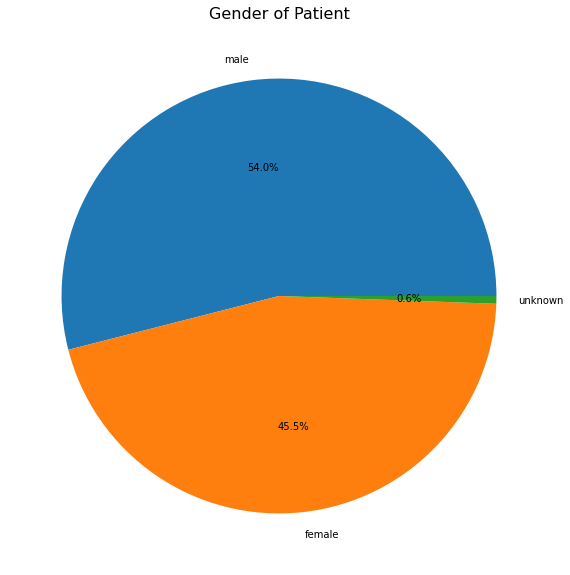

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(mdf['sex'].value_counts(), labels = mdf['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

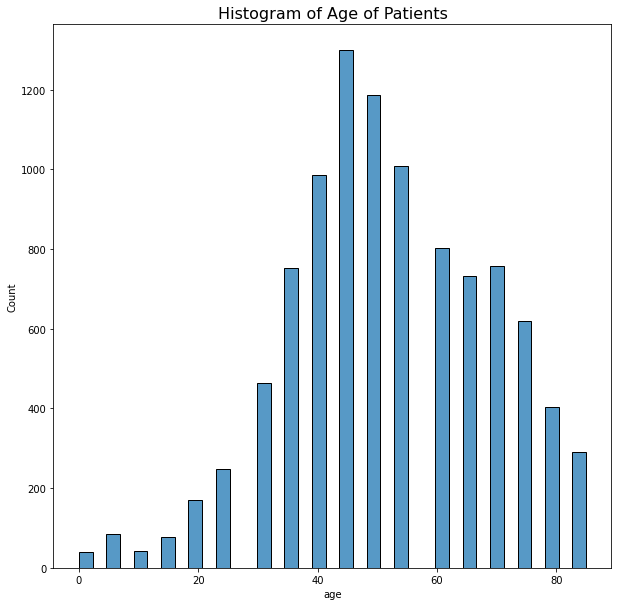

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(mdf['age'])
plt.title('Histogram of Age of Patients', size=16)

In [8]:
def create_classifier(learning_rate, num_dense_layers, num_dense_nodes, batch_size):
    classifier = Sequential()
    classifier.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu'))
    classifier.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2,2)))
    classifier.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    classifier.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2,2)))
    classifier.add(Flatten())
    for i in range(num_dense_layers):
        classifier.add(Dense(num_dense_nodes, activation='relu'))
    classifier.add(Dense(7, activation='softmax'))
    classifier.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate),
                  metrics = ['accuracy'])
    return classifier

In [9]:
@use_named_args(dimensions=dimensions)
def objective(learning_rate, num_dense_layers, num_dense_nodes, batch_size):
    classifier = create_classifier(learning_rate, num_dense_layers, num_dense_nodes, batch_size)
    history = classifier.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=batch_size,
                        epochs=50,
                        verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    return -val_acc  # maximize validation accuracy

In [10]:
result = gp_minimize(objective, dimensions=dimensions, n_calls=20, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 208.0566
Function value obtained: -0.9815
Current minimum: -0.9815
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 204.5382
Function value obtained: -0.9819
Current minimum: -0.9819
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 144.1765
Function value obtained: -0.9783
Current minimum: -0.9819
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 132.6085
Function value obtained: -0.4719
Current minimum: -0.9819
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 182.1821
Function value obtained: -0.5639
Current minimum: -0.9819
Iteration No: 6

In [12]:
best_learning_rate = result.x[0]
best_num_dense_layers = result.x[1]
best_num_dense_nodes = result.x[2]
best_batch_size = result.x[3]
best_val_acc = -result.fun
print(f"Best hyperparameters:\n"
      f"Learning rate: {best_learning_rate:.1e}\n"
      f"Number of dense layers: {best_num_dense_layers}\n"
      f"Number of dense nodes: {best_num_dense_nodes}\n"
      f"Batch size: {best_batch_size}\n"
      f"Validation accuracy: {best_val_acc:.4f}")

Best hyperparameters:
Learning rate: 8.7e-04
Number of dense layers: 1
Number of dense nodes: 512
Batch size: 120
Validation accuracy: 0.9824


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
